In [277]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Домашнее задание №7

[Задача 1](#Pr1) \
[Задача 2](#Pr2) \
[Задача 3](#Pr3) \
[Задача 4](#Pr4)

**Алгоритм kNN:**
  
Для каждого объекта $u$ тестовой выборки:

1. Найти расстоение до каждого объекта $x$ обучающей выборки;

2. Выбрать $k$ объектов, расстояние до которых минимально;

3. В случае классификации: отнести объект к классу, к которому относится большинство из выбранных $k$ ближайших соседей:
$$a(u) = \underset{y}{\text{argmax}}\sum_{i=1}^{k}[y_{u}^{(i)}=y].$$
  
  В случае регрессии: вычислить среднее значение ответа среди $k$ соседей:
  $$a(u) = \frac{1}{k}\sum_{i=1}^{k}y_{u}^{(i)}.$$

**Важно:** 
1) на этапе обучения не строится модель, а просто запоминается обучающая выборка; \
2)  перед работой по алгоритму kNN требуется проводить нормализацию признаков.

**При работе с алгоритмом требуется:**
1) подобрать количество соседей $k$; \
2) выбрать метрику; \
3) определить способ вычисления весов.

**Задача 1.** К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. <a class="anchor" id="Pr1"></a>

Загружаем датасет из sklearn

In [278]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [279]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

Визуализируем данные

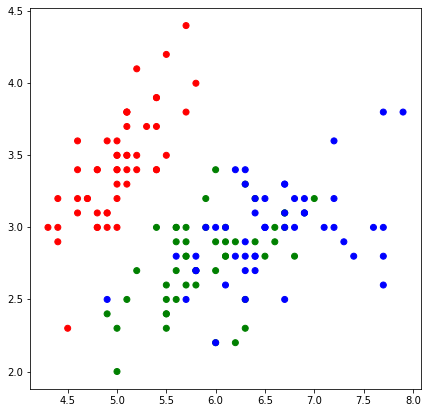

In [280]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [281]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

Реализуем алгоритм kNN

Будем добавлять "соседям" $x_i$ веса, зависящие от их порядкового номера: 
$$w(x_i) = w(i) = q^{i},$$ 
где $q \in (0,1)$.

In [282]:
def weight_num(i,q):
    return q ** i 

In [283]:
def weighed_num_knn(x_train, y_train, x_test, k, q):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        # и начальными нулевыми значениями сумм весов их элементов
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и находим k ближайших соседей
        kheighbors = sorted(test_distances)[0:k]
        
        # Каждому классу ставим в соответствие сумму весов его элементов, 
        #попавших в число k ближайших соседей 
        for i in range(len(kheighbors)):
            classes[kheighbors[i][1]] += weight_num(i,q)
                    
        # Записываем в ответ класс, сумма весов по которому максимальна
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [284]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [285]:
def weighed_knn_get_graph(weighted_knn_alg, X_train, y_train, k, q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = weighted_knn_alg(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Функция получения результата

In [286]:
def weighed_knn_result(weighted_knn_alg, X_train, y_train, X_test, k, q):
    y_pred = weighted_knn_alg(X_train, y_train, X_test, k, q)
    print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
    weighed_knn_get_graph(weighted_knn_alg, X_train, y_train, k, q)

Вычислим метрики качества и визуализируем разделяющую гиперплоскость при различных значения $k$

Точность алгоритма при k = 1: 0.667


<ipython-input-285-ed6c77d98105>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


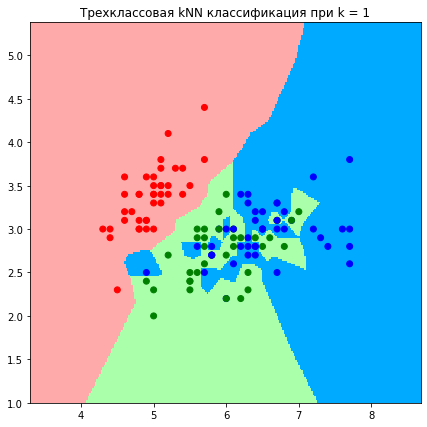

Точность алгоритма при k = 3: 0.733


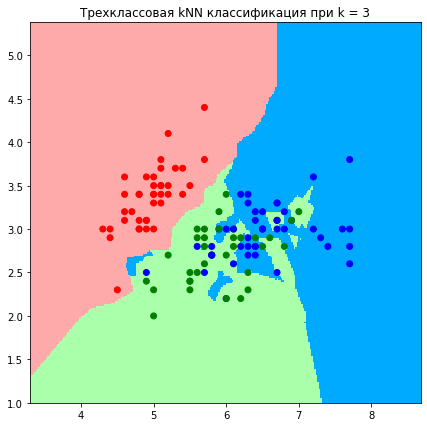

Точность алгоритма при k = 5: 0.867


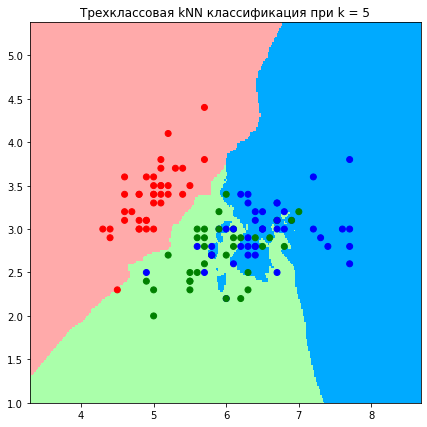

Точность алгоритма при k = 7: 0.833


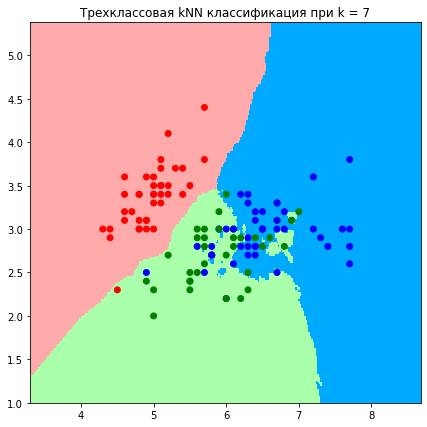

Точность алгоритма при k = 10: 0.867


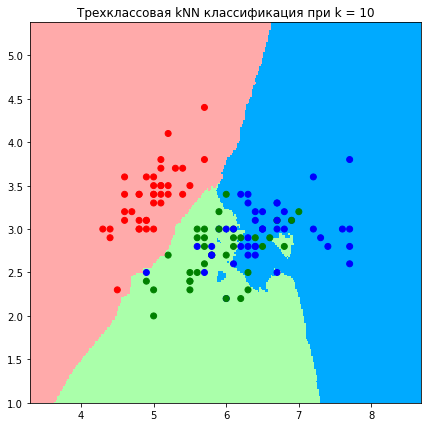

In [287]:
q = 0.9
for k in [1, 3, 5, 7, 10]:
    weighed_knn_result(weighed_num_knn,X_train, y_train, X_test, k, q)

**Вывод:** чем проще разделяющая гиперплоскость, тем выше метрика качества (алгоритм меньше концентрируется на выбросах).

**Задача 2**. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости.  <a class="anchor" id="Pr2"></a>

Реализуем алгоритм kNN

Будем добавлять "соседям" $x_i$ веса, зависящие от расстояния $d=distance(x,x_i)$ до классифицируемого объекта $x$: 
$$w(x_i) = w(d) = q^{d},$$ 
где $q \in (0,1)$.

In [288]:
def weight_dist(d,q):
    return q ** d 

In [289]:
def weighed_dist_knn(x_train, y_train, x_test, k, q):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        # и начальными нулевыми значениями сумм весов их элементов
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и находим k ближайших соседей
        kheighbors = sorted(test_distances)[0:k]
        
        # Каждому классу ставим в соответствие сумму весов его элементов, 
        #попавших в число k ближайших соседей 
        for d in kheighbors:
            classes[d[1]] += weight_dist(d[0],q)
                    
        # Записываем в ответ класс, сумма весов по которому максимальна
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Вычислим метрики качества и визуализируем разделяющую гиперплоскость при различных значения $k$

Точность алгоритма при k = 1: 0.667


<ipython-input-285-ed6c77d98105>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


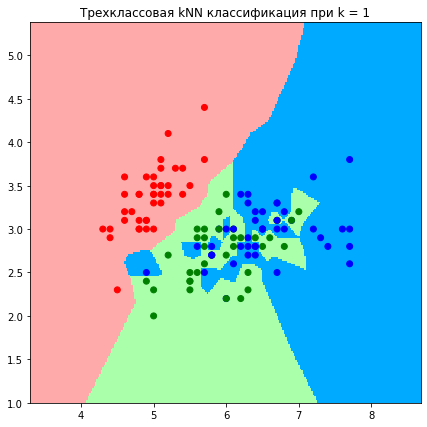

Точность алгоритма при k = 3: 0.733


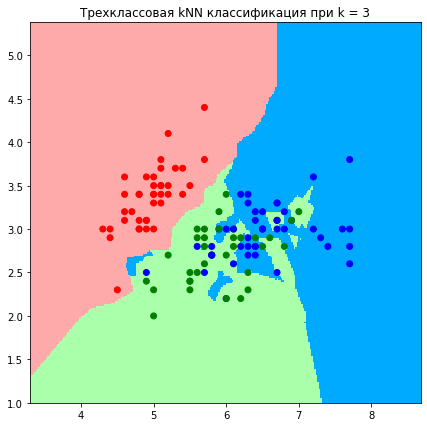

Точность алгоритма при k = 5: 0.867


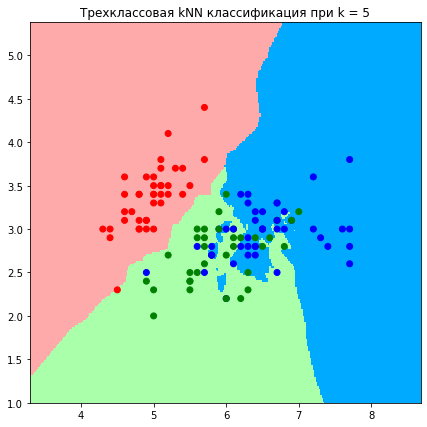

Точность алгоритма при k = 7: 0.800


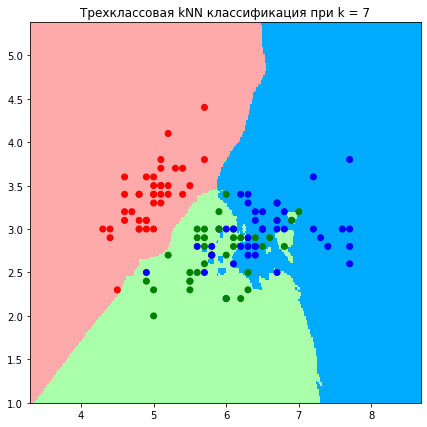

Точность алгоритма при k = 10: 0.867


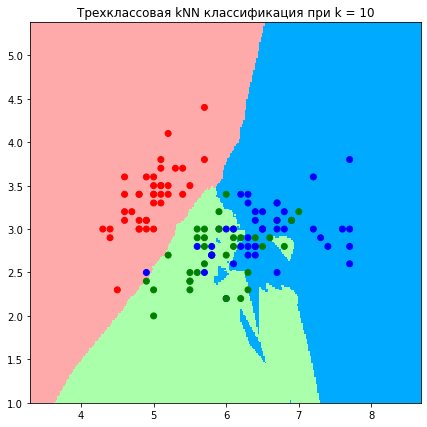

In [290]:
q = 0.9
for k in [1, 3, 5, 7, 10]:
    weighed_knn_result(weighed_dist_knn,X_train, y_train, X_test, k, q)

**Вывод:** чем проще разделяющая гиперплоскость, тем выше метрика качества (алгоритм меньше концентрируется на выбросах).

**Задача 3.** Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.  <a class="anchor" id="Pr3"></a> 

**Найдем оптимальные параметры $q$ и $k$ для алгоритма из [задачи 1](#Pr1).**

Сначала определим оптимальное значение параметра q

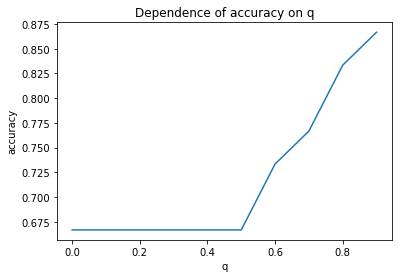

In [291]:
k = 10
q = np.arange(0,1,0.1)
accur = [accuracy(weighed_num_knn(X_train, y_train, X_test, k, i), y_test) for i in q]
plt.plot(q, accur)
plt.title('Dependence of accuracy on q')
plt.xlabel('q')
plt.ylabel('accuracy')
plt.show()

Оптимальное значение параметра q = 0.9

Теперь определим оптимальное число соседей

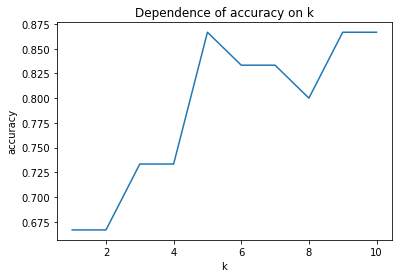

In [292]:
q = 0.9
k = range(1,11,1)
accur = [accuracy(weighed_num_knn(X_train, y_train, X_test, i, q), y_test) for i in k]
plt.plot(k, accur)
plt.title('Dependence of accuracy on k')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

Оптимальное значение параметра k = 5

Реализуем алгоритм с найденными оптимальными параметрами q = 0.9, k = 5

Точность алгоритма при k = 5: 0.867


<ipython-input-285-ed6c77d98105>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


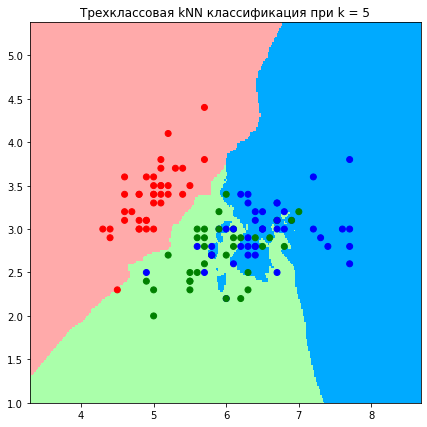

In [293]:
k = 5
q = 0.9
weighed_knn_result(weighed_num_knn,X_train, y_train, X_test, k, q)

**Вывод 1:** оптимальное количество соседей $k$ зависит от величины $q$: монотонно возрастает с ростом $q$ до определенного значения (при $q\leq 0.5$ оптимальное значение $k = 1$, при $q = 0.6$ -- $k = 4$, при $q = 0.7$ -- $k = 7$, при $q = 0.8$ -- $k = 6$, при $q = 0.9$ -- $k = 5$).

**Вывод 2:** разделяющая гиперплоскость очень похожа (более точнее) на разделяющую гиперплоскость из задачи урока (k = 5, без добавления весов). Значение accuracy такое же, как и в задаче из урока (k = 5, без добавления весов).

**Найдем оптимальные параметры $q$ и $k$ для алгоритма из [задачи 2](#Pr2).**

Сначала определим оптимальное значение параметра q

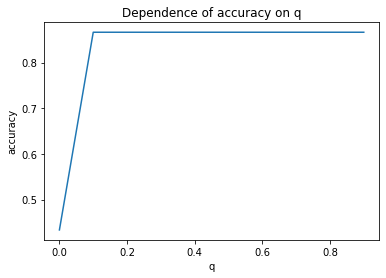

In [294]:
k = 10
q = np.arange(0,1,0.1)
accur = [accuracy(weighed_dist_knn(X_train, y_train, X_test, k, i), y_test) for i in q]
plt.plot(q, accur)
plt.title('Dependence of accuracy on q')
plt.xlabel('q')
plt.ylabel('accuracy')
plt.show()

Оптимальное значение параметра q = 0.1

Теперь определим оптимальное число соседей

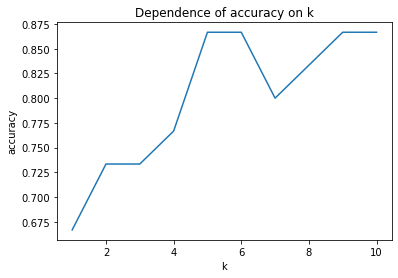

In [295]:
q = 0.1
k = range(1,11,1)
accur = [accuracy(weighed_dist_knn(X_train, y_train, X_test, i, q), y_test) for i in k]
plt.plot(k, accur)
plt.title('Dependence of accuracy on k')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

Оптимальное значение параметра k = 5

Реализуем алгоритм с найденными оптимальными параметрами q = 0.1, k = 5

Точность алгоритма при k = 5: 0.867


<ipython-input-285-ed6c77d98105>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


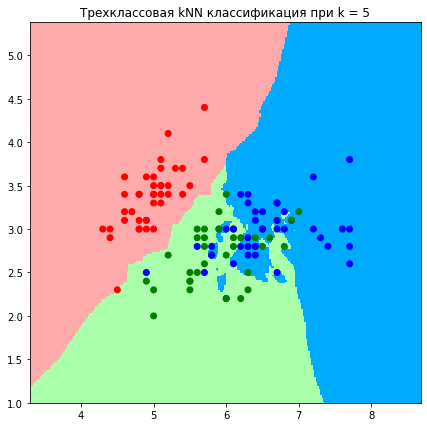

In [296]:
k = 5
q = 0.1
weighed_knn_result(weighed_dist_knn,X_train, y_train, X_test, k, q)

**Вывод 3:** оптимальное количество соседей $k$ не зависит от величины $q$: при любом $q\in (0,1)$ оптимальное значение $k = 5$.

**Вывод 4:** разделяющая гиперплоскость очень похожа (более точнее) на разделяющую гиперплоскость из задачи урока (k = 5, без добавления весов). Значение accuracy такое же, как и в задаче из урока (k = 5, без добавления весов).

**Вывод 5:** Если использовать веса для "соседей", зависящие от их номера (задача 1), то оптимальное количество соседей $k$ зависит от величины $q \in (0,1)$, монотонно возрастая до определенного значения. Оптимальные параметры $q = 0.9$, $k = 5$. Если использовать веса для "соседей", зависящие от расстояния до классифицируемого объекта (задача 2), то оптимальное количество соседей $k$ не зависит от величины $q \in (0,1)$ и равно 5.

Сравним метрики качества и сложность разделяющей гиперплоскости для моделей из задач 1 и 2.

In [297]:
def get_graph(X_train, y_train, k, q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z1 = weighed_num_knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)
    Z2 = weighed_dist_knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)

    # Построим график
    Z1 = np.array(Z1).reshape(xx.shape)
    Z2 = np.array(Z2).reshape(xx.shape)
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(xx, yy, Z1, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Weighted kNN k = {k}")
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, Z2, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Weighted kNN k = {k}")
    
    plt.tight_layout()
    plt.show()

<ipython-input-297-4257d0c4d1f8>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z1, cmap=cmap_light)
<ipython-input-297-4257d0c4d1f8>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z2, cmap=cmap_light)


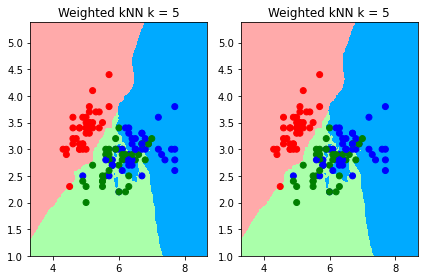

In [298]:
k = 5
q = 0.9
get_graph(X_train, y_train, k, q)

**Вывод 6:** при использовании параметров $q = 0.9$, $k = 5$ оба алгоритма имеют одну и ту же метрику качества и схожие гиперплоскости. Следовательно, ни один из способ "взвешивания" не имеет приоритета при реализации алгоритма kNN.

**Задача 4*.** Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).<a class="anchor" id="Pr4"></a>

**Кластреризация** (обучение без учителя)-- задача разделения объектов $x_1, x_2, \ldots, x_n$ на группы (поставить каждому объету метку $y_1, y_2, \ldots y_n$) так, что бы объекты с одной и той же меткой были похожи, а с разными - нет. 

Сгенерируем три облака точек

In [299]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

Визуализируем данные

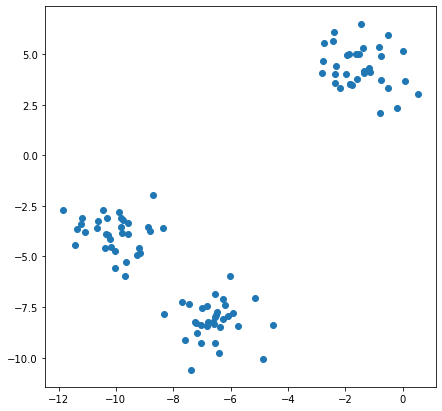

In [300]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

**Алгоритм k-means:**

1. Выбрать количество кластеров $k$, на которые будут делиться данные.

2. Случайным образом выбрать в пространстве данных $k$ точек $c_{k}$ (центроидов) - центров будущих кластеров.

3. Для каждой точки из выборки посчитать, к какому из центроидов она ближе.

4. Переместить каждый центроид в центр выборки, отнесенной к этому центроиду, определив его как среднее арифметическое всех точек кластера:

$$c_{k} = \frac{\sum_{i=1}^{l}[a(x_{i})=k]x_{i}}{\sum_{i=1}^{l}[a(x_{i}) = k]}.$$

5. Повторить шаги 3-4 до сходимости алгоритма (обычно это оценивается по величине смещения центроида после каждого шага - сходимость означает непревышение смещения какого-то заданного значения).

**Важно:** Результат работы алгоритма значительно зависит от начального выбора центроидов.

Реализация алгоритма k-means

In [301]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения с новыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

**Качество кластеризации** \
Используем внутренюю метрику, основанную на свойствах выборки и кластеров, --  среднее квадратичное внутриклассовое расстояние:

$$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

где $K$ - количество кластеров, $c_{k}$ - центр кластера.

Данный функционал нужно минимизировать.

In [302]:
def root_mean_square_intra_cluster_distance(centroids,clusters):
    intra_cluster_distance = 0
    for i in range(len(centroids)):
        distances = [e_metrics(element, centroids[i]) ** 2 for element in clusters[i]] 
        intra_cluster_distance += (1/(i+1)) * sum(distances)
    return intra_cluster_distance

Функция визуализации кластеров

In [303]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

Пример работы алгоритма

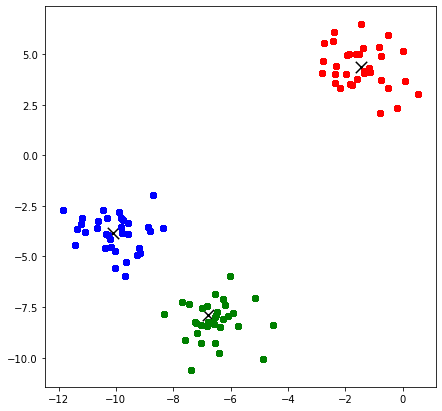

Cреднее квадратичное внутрикластерное расстояние: 1250.9480335096773


In [304]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

print(f'Cреднее квадратичное внутрикластерное расстояние: {root_mean_square_intra_cluster_distance(centroids,clusters)}')

Построим график зависимости среднего квадратичного внутрикластерного расстояния от количества кластеров

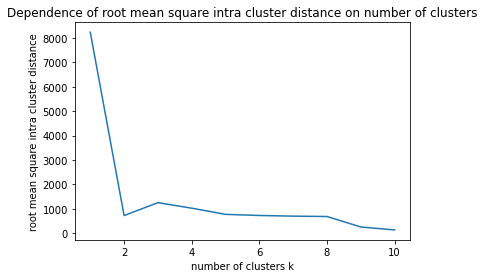

In [305]:
max_iterations = 10
min_distance = 1e-4

k = [i for i in range(1,11)]
metric = []
for i in k:
    centroids, clusters = kmeans(X, i, max_iterations, min_distance)
    rmsicd = root_mean_square_intra_cluster_distance(centroids,clusters)
    metric.append(rmsicd)
plt.title('Dependence of root mean square intra cluster distance on number of clusters')
plt.xlabel('number of clusters k')
plt.ylabel('root mean square intra cluster distance')
plt.plot(k,metric)
plt.show()

При увеличении количества кластеров $k$ величина среднего квадратичного внутрикластерного расстояния уменьшается, достигая наименьшего значения при $k = 10$.

Оптимальное количество кластеров $k = 2$.

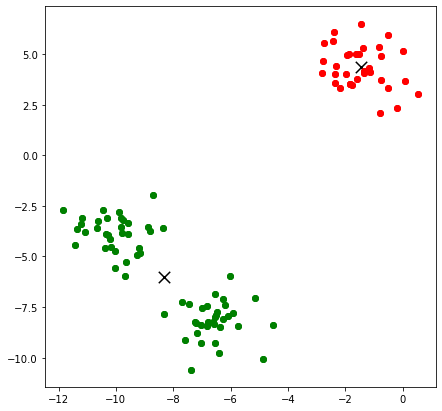

Cреднее квадратичное внутрикластерное расстояние: 721.7415521904394


In [306]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance= 1e-4

# сразу определим известное нам количество кластеров
k = 2

centroids, clusters = kmeans(X, k, max_iterations, min_distance)
visualize(centroids, clusters)
print(f'Cреднее квадратичное внутрикластерное расстояние: {root_mean_square_intra_cluster_distance(centroids,clusters)}')

**Вывод:** При увеличении количества кластеров величина среднего квадратичного внутрикластерного расстояния уменьшается.